### The Value of Transfer Learning Part I: Using Tweets to Compare SVM and Pre-Trained BERT Classifiers

 - By [Isaac Revette](https:/https://ihr0008.github.io//)

# Introduction:
 - The purpose of this is to highlight the power of **transfer learning** to help avoid the cold start problem when using deep learning models.
 - I will be using the State-of-the-art BERT Model released by Google, the description of it is as follows:
 - "*Bidirectional Encoder Representations from Transformers is a technique for NLP pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google. Google is leveraging BERT to better understand user searches."*
 - The classification problem will be identifing whether a tweet is positive or negative.
 - Enjoy!
 


# To identify whether a tweet is positive or negative, we will:
 - Train an Support Vector Classifier 
 - Use Sklearn to train and tune the SVC
 - Use SpaCy to tokenize text for the SVC
 - Fine Tune a Pre-trained BERT Model  
 - Use the huggingface Pytorch library to tune the BERT Model
 - Compare each model on a holdout dataset of tweets



### Load the Data from my Github Repository

In [0]:
import pandas as pd
train = pd.read_csv("https://raw.githubusercontent.com/ihr0008/Twitter-BERT/master/dev.tsv", sep ="\t", names = ['id', 'label', 'alpha','tweet'],)
test = pd.read_csv("https://raw.githubusercontent.com/ihr0008/Twitter-BERT/master/test.tsv", sep ="\t", names =['id', 'label', 'alpha','tweet'], skiprows=1)

In [0]:
import numpy as np
tweets = train.tweet.values
labels = train.label.values
labels = np.where(labels==4, 1, labels) # data has 0 & 4 in it, replace 4 with 1 for understanding
test_tweets = test.tweet.values
test_labels = test.label.values
test_labels = np.where(test_labels==4, 1, test_labels) # data has 0 & 4 in it, replace 4 with 1 for understanding

# Training the SVC

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy.cli


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
# Download the Large English NLP Package
print('Be patient, this can take a lil bit...')
#spacy.cli.download("en_core_web_lg")

# Load the Large English NLP Package of Spacy
nlp = spacy.load("en_core_web_lg")
print('Large English NLP Package loaded successfully!')

## First we have to create a process to tokenize and format our tweets so the SVC can interpret them.

In [0]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [0]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

To convert the text to vectors, I will include two ways:
 - Bag-of-Words with N-gram encoding
 - Tf-Idf (I will use Tf-Idf)

In [0]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

## Create the Pipeline with the SVC to do the training.

In [0]:
from sklearn.svm import SVC
classifier = SVC(random_state=213)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])


## Split the data into training and test
 - Split will be 80/20

In [0]:
# Use train_test_split 
from sklearn.model_selection import train_test_split

# Split tweets
X_train, X_valid, y_train, y_valid = train_test_split(tweets, labels, 
                                                            random_state=213, test_size=0.1)

## Training of the model and Evaluation

### Fit the Model

In [0]:
# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f89451ba160>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f885e8a11e0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
               

### Predict with the Model

In [0]:

predicted = pipe.predict(X_valid)

### Evaluate Model



Look at the Precision, Recall, F1, and Accuracy

In [0]:
from sklearn import metrics
print(metrics.classification_report(y_valid, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.710     0.737     0.723       749
           1      0.756     0.731     0.743       835

    accuracy                          0.734      1584
   macro avg      0.733     0.734     0.733      1584
weighted avg      0.734     0.734     0.734      1584



73% accuracy is not bad for a classifier.

Now Lets look at the Mathews Correlation Coefficient:
 - The scale of the MCC is from -1 to 1
 - -1 is the worst classifier
 - +1 is the best classifier

In [0]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_valid, predicted)

print('MCC: %.3f' % mcc)

MCC: 0.467


A decent MCC, its at least above 0.

Now lets plot the Area Under the Curve (AUC) / ROC Curve

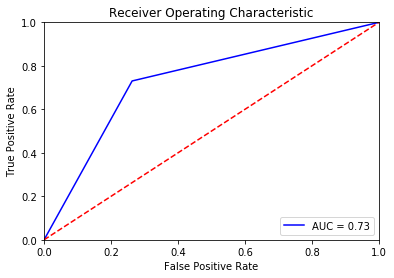

In [0]:
import matplotlib.pyplot as plt

# Retrieve the ROC/AUC
fpr, tpr, threshold = metrics.roc_curve(y_valid, predicted)
roc_auc = metrics.auc(fpr, tpr)


# Plot the ROC/AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


The initial Model with no hyper tuning performed well. The red line represents the equivalent of random guessing. The closer the blue line is to be a right angle in the top left, the better the classifier is performing.


# Tuning the BERT Model

### The first step is to identify the GPU we will use perform the training.


In [0]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch

#Look for GPU
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:

!pip install transformers

## Next we must tokenize the sentences with  BERTs Tokenizer

In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Lets test the tokenizer on one tweet:

In [0]:
# Original Tweet:
print(' Original: ', tweets[99])

# Split into Tokens:
print('Tokenized: ', tokenizer.tokenize(tweets[99]))

# Token ids:
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[99])))

 Original:  Writing interrupted by French Open tennis. 
Tokenized:  ['writing', 'interrupted', 'by', 'french', 'open', 'tennis', '.']
Token IDs:  [3015, 7153, 2011, 2413, 2330, 5093, 1012]


First we have to convert the tweets to Token IDs and add the [CLS] and [SEP] tokens that BERT requires.

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs
tweet_ids = []

for tweet in tweets:

    encoded_tweet = tokenizer.encode(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]
    )
    # Add the encoded sentence to the list
    tweet_ids.append(encoded_tweet)

# How Tweet and its IDs
print('Original: ', tweets[99])
print('Token IDs:', tweet_ids[99])

# Notice the Token IDs are different then above, thats the [CLS] and [SEP] Tokens
# Cool stuff ;)

Original:  Writing interrupted by French Open tennis. 
Token IDs: [101, 3015, 7153, 2011, 2413, 2330, 5093, 1012, 102]


We now have tweets as Token IDs with the special [CLS] and [SEP] Tokens added. 

Next we must pad and truncate the tweets so they the same length.

In [0]:
# Lets check the longest Tweet in our dataset
print('Max tweet length: ', max([len(tweet) for tweet in tweet_ids]))

Max tweet length:  125


While in our data the maximum is only 125, I think its worth using 280 because that is how long tweets can be.

In [0]:
# Use Keras Pad Sequence function
from keras.preprocessing.sequence import pad_sequences

#Set max length of input 
MAX_LEN = 284 # I added a few more than 280 just in case

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0
# "post" indicates that we want to pad and truncate at the end of the tweet
tweet_ids = pad_sequences(tweet_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 284 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


Now we have to tell BERT what is padding and what is a word using **attention masks**.
 - We can use 0 to refer to padding because BERT doesnt use that token ID
 

In [0]:
#Attention Masking
attention_masks = []

for tweet in tweet_ids:
    
    att_mask = [int(token_id > 0) for token_id in tweet]

    attention_masks.append(att_mask)

## Now we can split our training data into training and validation (90/10):

In [0]:
# Use train_test_split 
from sklearn.model_selection import train_test_split

# Split tweets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(tweet_ids, labels, 
                                                            random_state=213, test_size=0.1)
# Split masks too
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=213, test_size=0.1)

## The model needs PyTorch Tensors rather than numpy arrays so we need to convert them.



In [0]:
#Convert to pytorch tensor
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator for the data using the torch DataLoader class to save on memory:


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training (16 or 32 is recommended)

batch_size = 32

# Create the DataLoader for our training set:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) #Random for training data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data) #Sequential for validation data
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### If you are going to load the model and not train it, run cell below.


In [0]:
from transformers import *
import numpy as np
import time
import datetime
import random
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    # Takes time in seconds and returns a time string (hh:mm:ss)
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

## Now we begin the process of tuning our Pre-trained BERT Model. 
 - We will use huggingface's BertForSequenceClassification model
 - This will take a while (1 hour for me)
 - If you have model saved already, do not run this and skip to loading further down
 

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Initial Model
initial_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab and base (small) size
    num_labels = 2, # The number of output labels--2 for binary classification (You can increase this for multi-class tasks)  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


# Tell pytorch to run this model on the GPU
model.cuda()

### We can decide our optimization and learning rates for the model.
 - We will use a learning rate of 2e-5 
 - For our Optimizer, we will use the AdamW optimizer

In [0]:
# Use the AdamW optimizer from huggingface
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 # a small number to prevent any division by 0
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs (we chose a batch size of 32 so 32*4)
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Heres a function to help define accuracy and format time:

In [0]:
import numpy as np
import time
import datetime
import random
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    # Takes time in seconds and returns a time string (hh:mm:ss)
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

### This is the training loop for the model, note:
 - There is a lot going, but most of it is to make it pretty.
 - I did not write this loop code from scratch, its based on the run_glue.py script

In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed = 213

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# for each epoch
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    initial_model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        initial_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = initial_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(initial_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    initial_model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = initial_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    446.    Elapsed: 0:01:04.
  Batch    80  of    446.    Elapsed: 0:02:12.
  Batch   120  of    446.    Elapsed: 0:03:19.
  Batch   160  of    446.    Elapsed: 0:04:26.
  Batch   200  of    446.    Elapsed: 0:05:34.
  Batch   240  of    446.    Elapsed: 0:06:41.
  Batch   280  of    446.    Elapsed: 0:07:48.
  Batch   320  of    446.    Elapsed: 0:08:56.
  Batch   360  of    446.    Elapsed: 0:10:03.
  Batch   400  of    446.    Elapsed: 0:11:10.
  Batch   440  of    446.    Elapsed: 0:12:18.

  Average training loss: 0.46
  Training epcoh took: 0:12:27

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:31

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    446.    Elapsed: 0:01:07.
  Batch    80  of    446.    Elapsed: 0:02:15.
  Batch   120  of    446.    Elapsed: 0:03:22.
  Batch   160  of    446.    Elapsed: 0:04:29.
  Batch   200  of    446.    Elapsed: 0:05:37.
  Batch   240  of    446.    Elap

## Save the Model:
*Code imported from run_glue.py*

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
#Save to Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r ./model_save/ "./drive/My Drive/Saved Models/"

## Predictions and Evaluation from the Tuned BERT model

### Process Holdout Data

In [0]:
# Test data is test_tweets and test_labels

input_ids = []


for tweet in test_tweets:
    encoded_tweet = tokenizer.encode(
                        tweet,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_tweet)

# Same Max Length as above - 284
MAX_LEN = 284

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Load the Model from Google Drive (so we dont have to retrain)

In [0]:
from torch import nn

model_dir = "./drive/My Drive/Saved Models/model_save/"

model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)

# Copy the model to the GPU.
model.to(device)

### Getting Predictions

In [0]:


print('Predicting labels for {:,} test tweets...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('Done!')

Predicting labels for 15,682 test tweets...
Done!


### Evaluate BERT Model

 - taking predictions from the BERT is a bit tricky because the output in this case is the logit prediction of the texts semantic meaning
 - we have to convert all of it to one array of predictions

In [0]:
# Combine the predictions for each batch into a single list of 0 and 1 preds
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list
flat_true_labels = [item for sublist in true_labels for item in sublist]


Lets look at the Precision, Recall, F1, and Accuracy Report

In [0]:
from sklearn import metrics
print(metrics.classification_report(flat_true_labels, flat_predictions, digits=3))

              precision    recall  f1-score   support

           0      0.831     0.831     0.831      7862
           1      0.830     0.830     0.830      7820

    accuracy                          0.830     15682
   macro avg      0.830     0.830     0.830     15682
weighted avg      0.830     0.830     0.830     15682



83%! Thats around 10% better than the SVC we trained. The model is around 20% better than the SVC at predicting the semantic labels when compared to random (50%).

Lets Look at the Matthews Correlation Coefficient now


In [0]:
from sklearn.metrics import matthews_corrcoef

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.661


0.661 is pretty good, up from .467 with the SVC

Now we can plot the Area Under the Curve (AUC) / ROC Curve.

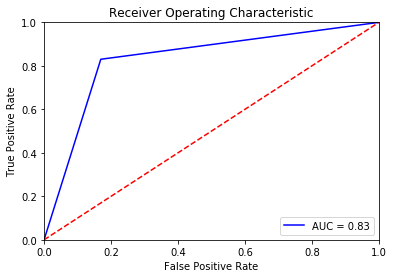

In [0]:
import matplotlib.pyplot as plt

# Retrieve the ROC/AUC
fpr, tpr, threshold = metrics.roc_curve(flat_true_labels, flat_predictions)
roc_auc = metrics.auc(fpr, tpr)


# Plot the ROC/AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Thats a pretty nice looking ROC Curve, right there! Especially considering the model was only trained on 15000 tweets. 




# Conclusion and Insights

### *Heres a few considerations before I draw insights:*
 - *The SVC performed well and could have performed better if I spent a good amount of time hyper tuning the parameters.*
 - *The BERT model is the base/small version and it could have been tuned a little more if I had the time and knowledge to do so.*
 - *I am by no means an expert in using BERT for NLP, rather I am a data science student with significant room to improve.*
 - *I used various online and academic resources to build this project and was by no means done on my own.*
 

### Comparatively, our predictions are incredibly accurate for only training on 15000 tweets.
 - For example, the [Kaggle Competition](https://www.kaggle.com/c/epfml-text/leaderboard) winner for semantic analysis of tweets achieved a validation score of **87.66%** (albeit 3 years ago). As well, they trained on **2.5 million** tweets, compared to our **15000**. 
 - Considering that, I hope you begin to realize the power of transfer learning combined with the state-of-the-art models.


### This project really highlights the power of Transfer learning for several reasons:
 - Most non-neural net models are pretty good when being trained on lower amounts of training data (less than 100,000 maybe) when compared to neural nets (which require a lot of data to really get good, but scale much better with more information).
 - Because of taking a pre-trained model and tuning only the top layer or neurons on this specific task, we can use the power of neural nets with limited amounts of data.
 - Transfer learning helps avoid the **Cold-start problem** that comes with neural nets, meaning we dont have to spend enourmous amounts of **time** and **moeny** to train a top of the line neural net from scratch.
 

### By using transfer learning, people and companies can utilize state-of-the-art deep learning models to make predictions without having to obtain enourmous amounts of data to train them.
 - All you need is a pretrained model and you can implement it on limited data problems.
 - This can help companies without a history of data collection or within new industries utilize the best machine learning algorithms like never before.

### All that being said, the more we train this model the better it will do! That takes time and money I do not have as a graduate student (at the time of this writing).

# Thank you!